In [ ]:
!git clone https://github.com/st-tech/zr-obp
!python zr-obp/setup.py install

fatal: destination path 'zr-obp' already exists and is not an empty directory.
version
0.5.5
INFO:root:running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
   

In [ ]:
!wget https://research.zozo.com/data_release/open_bandit_dataset.zip

--2025-03-28 01:24:47--  https://research.zozo.com/data_release/open_bandit_dataset.zip
Resolving research.zozo.com (research.zozo.com)... 18.239.208.32, 18.239.208.26, 18.239.208.12, ...
Connecting to research.zozo.com (research.zozo.com)|18.239.208.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412931917 (394M) [application/zip]
Saving to: ‘open_bandit_dataset.zip.1’

open_bandit_dataset 100%[===================>] 393.80M  17.0MB/s    in 38s     

2025-03-28 01:25:26 (10.3 MB/s) - ‘open_bandit_dataset.zip.1’ saved [412931917/412931917]



In [ ]:
!unzip open_bandit_dataset.zip

Archive:  open_bandit_dataset.zip.1
Made with MacWinZipper (http://tidajapan.com/macwinzipper)
  inflating: open_bandit_dataset/README  
  inflating: open_bandit_dataset/bts/all/item_context.csv  
  inflating: open_bandit_dataset/bts/all/all.csv  
  inflating: open_bandit_dataset/bts/men/item_context.csv  
  inflating: open_bandit_dataset/bts/men/men.csv  
  inflating: open_bandit_dataset/bts/women/item_context.csv  
  inflating: open_bandit_dataset/bts/women/women.csv  
  inflating: open_bandit_dataset/VERSION  
  inflating: open_bandit_dataset/random/all/item_context.csv  
  inflating: open_bandit_dataset/random/all/all.csv  
  inflating: open_bandit_dataset/random/men/item_context.csv  
  inflating: open_bandit_dataset/random/men/men.csv  
  inflating: open_bandit_dataset/random/women/item_context.csv  
  inflating: open_bandit_dataset/random/women/women.csv  


In [ ]:
%cd zr-obp

/content/zr-obp


In [ ]:
ls

 benchmark/                    docs/         obd/                pyproject.toml   slides/
'bts_UCB_policy_eps=-10.npy'   examples/     obp/                README_JN.md     tests/
 CONTRIBUTING.md               images/       pi_a_x_e_test.npy   README.md
 df_all_lin_ucb.csv            LICENSE       pi_a_x_e_test.zip   setup.cfg
 df_all_ucb_noisy.csv          MANIFEST.in   poetry.lock         setup.py


In [ ]:
from obp.dataset import OpenBanditDataset
from obp.policy import LinUCB

In [ ]:
from obp.dataset import OpenBanditDataset
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from dataclasses import dataclass
from obp.types import BanditFeedback
from typing import Union
from typing import Tuple
from sklearn.utils import check_random_state
from sklearn.utils import check_scalar

@dataclass
class ModifiedOpenBanditDataset(OpenBanditDataset):
    user_item_affinity_feat: bool = False
    user_feat: bool = True
    @property
    def n_actions(self) -> int:
        """Number of actions."""
        return int(self.action.max() + 1)

    def pre_process(self) -> None:
        """Preprocess raw open bandit dataset."""
        if self.user_feat and self.user_item_affinity_feat:
            user_cols = self.data.columns.str.contains("user_feature")
            user_context = pd.get_dummies(
                self.data.loc[:, user_cols], drop_first=True
            ).values
            user_item_cols = self.data.columns.str.contains("user-item_affinity")
            user_item_context = self.data.loc[:,user_item_cols].values
            #user_item_context = np.column_stack((user_item_context, np.ones(user_item_context.shape[0])))
            self.context = np.c_[user_context, user_item_context]
            #self.context = np.einsum('nk,nl->nkl', user_context, user_item_context).reshape(user_context.shape[0],-1)
        elif self.user_feat:
            user_cols = self.data.columns.str.contains("user_feature")
            self.context = pd.get_dummies(
                self.data.loc[:, user_cols], drop_first=True
            ).values
        elif self.user_item_affinity_feat:
            user_item_cols = self.data.columns.str.contains("user-item_affinity")
            self.context = self.data.loc[:,user_item_cols].values
        else:
            raise ValueError("one of the `user_item_affinity_feat` or `user_feat` must be True.")
        item_feature_0 = self.item_context["item_feature_0"].values
        item_feature_cat = self.item_context.drop(
            columns=["item_id", "item_feature_0"], axis=1
        ).apply(LabelEncoder().fit_transform)
        item_feature_cat = OneHotEncoder(sparse_output=False, drop="first").fit_transform(item_feature_cat)
        item_feat = np.c_[item_feature_cat, item_feature_0]
        self.action_context = np.zeros(((self.position.max()+1)* self.n_actions, item_feat.shape[1]+1))
        for i in range(self.position.max()+1):
            self.action_context[i*self.n_actions:(i+1)*self.n_actions,1:] = item_feat
            self.action_context[i*self.n_actions:(i+1)*self.n_actions,0] = np.ones(self.n_actions)*i
        # self.action_context = item_feat

        pos = DataFrame(self.position)
        self.action_context = (
            self.item_context.drop(columns=["item_id", "item_feature_0"], axis=1)
            .apply(LabelEncoder().fit_transform)
            .values
        )
        self.action_context = self.action_context[self.action]
        self.action_context = np.c_[self.action_context, pos]

        self.action = self.position * self.n_actions + self.action
        self.position = np.zeros_like(self.position)
        self.pscore /= 3
    def obtain_batch_bandit_feedback(
        self, test_size: float = 0.3, is_timeseries_split: bool = False
    ) -> Union[BanditFeedback, Tuple[BanditFeedback, BanditFeedback]]:
        """Obtain batch logged bandit data.

        Parameters
        -----------
        test_size: float, default=0.3
            Proportion of the dataset included in the test split.
            If float, should be between 0.0 and 1.0.
            This argument matters only when `is_timeseries_split=True` (the out-sample case).

        is_timeseries_split: bool, default=False
            If true, split the original logged bandit data into train and test sets based on time series.

        Returns
        --------
        bandit_feedback: BanditFeedback
            A dictionary containing batch logged bandit data collected by the behavior policy.
            The keys of the dictionary are as follows.
            - n_rounds: number of rounds, data size of the logged bandit data
            - n_actions: number of actions (:math:`|\mathcal{A}|`)
            - action: action variables sampled by the behavior policy
            - position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface
            - reward: binary reward variables, click indicators
            - pscore: action choice probabilities by the behavior policy, propensity scores
            - context: context vectors such as user-related features and user-item affinity scores
            - action_context: item-related context vectors

        """
        if not isinstance(is_timeseries_split, bool):
            raise TypeError(
                f"`is_timeseries_split` must be a bool, but {type(is_timeseries_split)} is given"
            )

        if is_timeseries_split:
            check_scalar(
                test_size,
                name="target_size",
                target_type=(float),
                min_val=0.0,
                max_val=1.0,
            )
            n_rounds_train = np.int32(self.n_rounds * (1.0 - test_size))
            bandit_feedback_train = dict(
                n_rounds=n_rounds_train,
                n_actions=self.n_actions,
                action=self.action[:n_rounds_train],
                position=self.position[:n_rounds_train],
                reward=self.reward[:n_rounds_train],
                pscore=self.pscore[:n_rounds_train],
                context=self.context[:n_rounds_train],
                action_context=self.action_context[:n_rounds_train],
            )
            bandit_feedback_test = dict(
                n_rounds=(self.n_rounds - n_rounds_train),
                n_actions=self.n_actions,
                action=self.action[n_rounds_train:],
                position=self.position[n_rounds_train:],
                reward=self.reward[n_rounds_train:],
                pscore=self.pscore[n_rounds_train:],
                context=self.context[n_rounds_train:],
                action_context=self.action_context[n_rounds_train:],
            )
            return bandit_feedback_train, bandit_feedback_test
        else:
            return dict(
                n_rounds=self.n_rounds,
                n_actions=self.n_actions,
                action=self.action,
                position=self.position,
                reward=self.reward,
                pscore=self.pscore,
                context=self.context,
                action_context=self.action_context,
            )



In [ ]:
data = ModifiedOpenBanditDataset(behavior_policy='bts', campaign='all', data_path='../open_bandit_dataset')

In [ ]:
bandit_feedback_train, bandit_feedback_test = data.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

8650040
3707160


In [ ]:
import numpy as np
from tqdm import tqdm
import math
from scipy.special import softmax

class LinUCB:
    def __init__(self, num_arms, user_features, item_features,
                 alpha):

        self.num_arms = num_arms
        self.user_features = user_features
        self.item_features = item_features


        self.d_u = user_features.shape[1]
        self.d_i = item_features.shape[1]
        self.d = self.d_u + self.d_i

        self.alpha = alpha

        # For each arm D[a], b[a]
        self.D = [[] for _ in range(num_arms)]
        self.b = [[] for _ in range(num_arms)]

        self.A = [None]*num_arms
        self.A_inv = [None]*num_arms
        self.rhs = [None]*num_arms

        for a in range(num_arms):
            self.A[a] = np.eye(self.d)
            self.A_inv[a] = np.linalg.inv(self.A[a])
            self.rhs[a] = np.zeros(self.d)

    def _concat_features(self, user_context, a):
        x_u = user_context                   # сразу переданный контекст пользователя
        x_a = self.item_features[a]
        return np.concatenate([x_u, x_a])


    def append_interaction(self, user_context, a, r):
        x_ua = self._concat_features(user_context, a)
        self.D[a].append(x_ua)
        self.b[a].append(r) #the corresponding m click/no-click user feedback


    def batch_update(self, arms=None):
        if arms is None:
            arms = range(self.num_arms)

        for a in arms:
            if len(self.D[a]) == 0:
                continue

            D_a = np.array(self.D[a])
            b_a = np.array(self.b[a])


            self.A[a] += D_a.T @ D_a
            self.A_inv[a] = np.linalg.inv(self.A[a])
            self.rhs[a] += D_a.T @ b_a

    def train(self, train_data, batch_size):
        num_batches = math.ceil(len(train_data)/batch_size)
        idx = 0
        for _ in tqdm(range(num_batches), desc="Training"):
            batch = train_data[idx : idx+batch_size]
            idx += batch_size

            # 1) Append interactions
            self.D = [[] for _ in range(num_arms)]
            self.b = [[] for _ in range(num_arms)]
            for (u, a, r) in batch:
                self.append_interaction(u, a, r)

            self.batch_update(arms=None)


In [ ]:
num_arms = bandit_feedback_train['n_actions']
user_features = bandit_feedback_train['context']
item_features = bandit_feedback_train['action_context'][:num_arms]

alpha = -10

linucb_model = LinUCB(
    num_arms=num_arms,
    user_features=user_features,
    item_features=item_features,
    alpha=alpha
)


In [ ]:
train_contexts = bandit_feedback_train['context']
train_actions = bandit_feedback_train['action']
train_rewards = bandit_feedback_train['reward']

train_data = [
    (train_contexts[i], train_actions[i], train_rewards[i])
    for i in range(len(train_rewards))
]



In [ ]:
import math
batch_size = 10000

linucb_model.train(train_data, batch_size)


Training: 100%|██████████| 866/866 [00:41<00:00, 20.66it/s]


In [ ]:
import numpy as np
from scipy.special import softmax
from tqdm import tqdm

def predict_softmax_probabilities_armwise(model, test_contexts, temperature=1.0):
    n_users = test_contexts.shape[0]
    num_items = model.num_arms

    payoffs = np.zeros((n_users, num_items))

    for a in tqdm(range(num_items), desc="Predicting probabilities (arm-wise)"):
        x_a = model.item_features[a]
        A_inv_a = model.A_inv[a]
        theta_a = model.A_inv[a] @ model.rhs[a]

        x_ua = np.hstack((test_contexts, np.tile(x_a, (n_users, 1))))

        exploration = model.alpha * np.sqrt((x_ua.dot(A_inv_a) * x_ua).sum(axis=1))
        payoffs[:, a] = x_ua @ theta_a + exploration

    probabilities = softmax(payoffs / temperature, axis=1)
    probabilities = probabilities[:, :, np.newaxis]

    return probabilities


In [ ]:
from scipy.special import softmax

class OfflineUCB:
    def __init__(self, n_actions, actions, rewards, n_rounds):
        self.n_actions = n_actions
        self.n_rounds = n_rounds
        self.actions = np.array(actions, dtype=int).flatten()
        self.rewards = np.array(rewards, dtype=float).flatten()

        # Проверяем, что размеры совпадают
        assert self.actions.shape == self.rewards.shape, "actions и rewards должны иметь одинаковую длину"

    def compute_ucb(self):
        if self.actions.ndim != 1 or self.rewards.ndim != 1:
            raise ValueError("actions и rewards должны быть одномерными массивами")

        # Подсчет количества выборов каждого действия
        counts = np.bincount(self.actions, minlength=self.n_actions).astype(float)

        # Подсчет суммы наград для каждого действия
        if len(self.rewards) == len(self.actions):
            reward_sums = np.bincount(self.actions, weights=self.rewards, minlength=self.n_actions).astype(float)
        else:
            raise ValueError("Ошибка: длины actions и rewards не совпадают")

        # Вычисление средних наград (избегаем деления на 0)
        values = reward_sums / (counts)

        # Вычисление UCB
        ucb_values = values + np.sqrt(2 * np.log(self.n_rounds) / (counts))
        return ucb_values

    def select_best_action(self, n_users):
        ucb_values = self.compute_ucb()
        ucb_values = softmax(ucb_values)
        ucb_score = np.tile(ucb_values, (n_users, 1))
        return np.expand_dims(ucb_score, axis=-1)


In [ ]:
test_contexts = bandit_feedback_test['context']
softmax_probabilities = predict_softmax_probabilities_armwise(
    linucb_model, test_contexts, temperature=0.5
)

print(softmax_probabilities.shape)



Predicting probabilities (arm-wise): 100%|██████████| 240/240 [08:55<00:00,  2.23s/it]


(3707160, 240, 1)


In [ ]:
np.save(f'bts_lin_ucb_policy_eps=-10_', softmax_probabilities)

In [ ]:
!zip bts_lin_ucb_policy_eps=-10_.zip bts_lin_ucb_policy_eps=-10_.npy

  adding: bts_lin_ucb_policy_eps=-10_.npy (deflated 80%)


In [ ]:
from typing import Dict, List, Tuple

import numpy as np
from obp.ope import RegressionModel
from sklearn.linear_model import LogisticRegression

def get_est_rewards_by_reg(n_actions, len_list, bandit_feedback_train, bandit_feedback_test):
    """
    Fit Logistic Regression to rewards from `bandit_feedback`.
    """
    regression_model = RegressionModel(
        n_actions=n_actions,
        len_list=len_list,
        action_context=bandit_feedback_train["action_context"],
        base_model=LogisticRegression(max_iter=1000, random_state=12345),
    )

    regression_model.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    estimated_rewards_by_reg_model = regression_model.predict(
        context=bandit_feedback_test["context"],
    )

    return estimated_rewards_by_reg_model

In [ ]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(bandit_feedback_train['n_actions'],
                                                        1,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

In [ ]:
pi_a_x_e_estimator = LogisticRegression(max_iter=100, random_state=12345)
X = np.c_[bandit_feedback_train['context'][:1000000], bandit_feedback_train['action_context'][:1000000]]
action = bandit_feedback_train['action'][:1000000]

In [ ]:
pi_a_x_e_estimator.fit(X, action)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=12345)

In [ ]:
x_e = np.c_[bandit_feedback_test['context'], bandit_feedback_test['action_context']]
pi_a_x_e_test = pi_a_x_e_estimator.predict_proba(x_e)

In [ ]:
!zip pi_a_x_e_test.zip pi_a_x_e_test.npy

  adding: pi_a_x_e_test.npy (deflated 19%)


In [ ]:
from sklearn.cluster import MiniBatchKMeans
def ipw(pi_e, pi_0, r, r_hat):
    weights = pi_e/pi_0
    return weights * r

def snipw(pi_e, pi_0, r, r_hat):
    weights = pi_e/pi_0
    weights = weights/weights.mean()
    return weights * r

def sndr(pi_e, pi_0, r, r_hat, dm):
    weights = pi_e/pi_0
    weights = weights/weights.mean()
    return dm + weights*(r-r_hat)

def dr(pi_e, pi_0, r, r_hat, dm):
    weights = pi_e/pi_0
    return dm + weights*(r-r_hat)

def dm(dm):
    return dm

def chips(pi_e, pi_0, r, r_hat, clusters, actions):
    a = 3
    unique_pairs = np.unique(list(zip(clusters, actions)), axis=0)

    pi_e_means = np.zeros_like(pi_e)
    pi_0_means = np.zeros_like(pi_0)
    r_means = np.zeros_like(r, dtype=float)

    for cluster, action in unique_pairs:
        mask = (clusters == cluster) & (actions == action)
        pi_e_means[mask] = pi_e[mask].mean()
        pi_0_means[mask] = pi_0[mask].mean()
        r_means[mask] = (r[mask].sum() + a - 1) / (mask.sum() + 2 * a - 2)

    return (pi_e_means / pi_0_means) * r_means
def chips_modified(pi_e_full, pi_0, r, r_hat, clusters, actions):
    a = 3
    unique_pairs = np.unique(list(zip(clusters, actions)), axis=0)

    pi_e_means = np.zeros_like(pi_0)
    pi_0_means = np.zeros_like(pi_0)
    r_means = np.zeros_like(r, dtype=float)

    for cluster, action in unique_pairs:
        mask_1 = (clusters == cluster)
        mask_2 = mask_1 & (actions == action)
        pi_e_means[mask_1] = pi_e_full.squeeze()[mask_1].mean(axis = 1)
        pi_0_means[mask_2] = pi_0[mask_2].mean()
        r_means[mask_2] = (r[mask_2].sum() + a - 1) / (mask_2.sum() + 2 * a - 2)

    return (pi_e_means / pi_0_means) * r_means

def mips(pi_e, pi_0, r, pi_a_x_e, actions):
    unique_actions = np.unique(actions)
    avg_pi_0 = np.zeros(240)
    # Efficiently compute avg_pi_0 using np.bincount (avoids looping)
    for a in unique_actions:
        avg_pi_0[a] = pi_0[actions == a].mean()

    # Compute weights directly
    weights = np.divide(pi_e.squeeze(), avg_pi_0, out=np.zeros_like(pi_e.squeeze()), where=avg_pi_0!= 0)

    # Compute marginal weights efficiently
    marginal_weights = np.einsum('ij,ij->i', weights, pi_a_x_e)

    return marginal_weights * r

In [ ]:
!unzip ../bts_UCB_policy_eps=-10.zip

Archive:  ../bts_UCB_policy_eps=-10.zip
  inflating: bts_UCB_policy_eps=-10.npy  


In [ ]:
all_action_dist_1 = np.load(f"bts_UCB_policy_eps=-10.npy")
# all_action_dist_2 = np.load(f"bts_lin_ucb_policy_eps=-10.npy")
# all_action_dist_3 = np.load(f"bts_lin_ucb_policy_eps=-10_.npy")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
kmeans = MiniBatchKMeans(n_clusters=8,
                            random_state=42,
                            batch_size=1024,
                            max_iter=1000,
                            n_init="auto").fit(bandit_feedback_train['context'])
clasters = kmeans.predict(bandit_feedback_test['context'])

In [ ]:
r_hat = estimated_rewards_by_reg_model[np.arange(bandit_feedback_test['action'].shape[0]), bandit_feedback_test['action'], 0]
DM_method_1 = (estimated_rewards_by_reg_model * all_action_dist_1).sum(axis = 1).squeeze()

In [ ]:
test_sizes = [50000, 100000, 500000]+ [bandit_feedback_test['n_rounds']//5*i for i in range(1,4)] + [bandit_feedback_test['n_rounds']]

In [ ]:
def run_exp(all_action_dist, DM_method):
    metrics = ['ipw', 'snipw', 'dr', 'sndr', 'dm', 'chips', 'chips_mod', 'mips']
    pi_e = all_action_dist[np.arange(bandit_feedback_test['action'].shape[0]), bandit_feedback_test['action'], 0].copy()
    cnt_inner_bootstraps = 100
    _alpha = 0.05
    CIs = []
    for n_size in test_sizes:
        res = {}
        pi_e_subset = pi_e[:n_size].copy()
        r_hat_subset = r_hat[:n_size].copy()
        r_subset = bandit_feedback_test['reward'][:n_size].copy()
        dm_subset = DM_method[:n_size].copy()
        stats = {}
        print(n_size)
        for metric in metrics:
            stats[metric] = []
        behavior_policies = bandit_feedback_test['pscore']

        pi_0_subset= behavior_policies[:n_size]
        ipw_est_round_rewards = ipw(pi_e_subset, pi_0_subset, r_subset, r_hat_subset)
        snipw_est_round_rewards = snipw(pi_e_subset, pi_0_subset, r_subset, r_hat_subset)
        sndr_est_round_rewards = sndr(pi_e_subset, pi_0_subset, r_subset, r_hat_subset, dm_subset)
        dr_est_round_rewards = dr(pi_e_subset, pi_0_subset, r_subset, r_hat_subset, dm_subset)
        dm_est_round_rewards = dm(dm_subset)
        chips_est_round_rewards = chips(pi_e_subset, pi_0_subset, r_subset, r_hat_subset, clasters[:n_size], bandit_feedback_test['action'][:n_size])
        chips_mod_est_round_rewards = chips_modified(all_action_dist[:n_size], pi_0_subset, r_subset, r_hat_subset, clasters[:n_size], bandit_feedback_test['action'][:n_size])
        mips_est_round_rewards = mips(all_action_dist[:n_size], pi_0_subset, r_subset, pi_a_x_e_test[:n_size],  bandit_feedback_test['action'][:n_size])
        for j in range(cnt_inner_bootstraps):
            bootstrap_idxs = np.random.randint(n_size, size=n_size)
            stats['ipw'].append(ipw_est_round_rewards[bootstrap_idxs].mean())
            stats['snipw'].append(snipw_est_round_rewards[bootstrap_idxs].mean())
            stats['sndr'].append(sndr_est_round_rewards[bootstrap_idxs].mean())
            stats['dm'].append(dm_est_round_rewards[bootstrap_idxs].mean())
            stats['dr'].append(dr_est_round_rewards[bootstrap_idxs].mean())
            stats['chips'].append(chips_est_round_rewards[bootstrap_idxs].mean())
            stats['chips_mod'].append(chips_mod_est_round_rewards[bootstrap_idxs].mean())
            stats['mips'].append(mips_est_round_rewards[bootstrap_idxs].mean())
        for metric in metrics:
            dct = {}
            values = stats[metric]
            dct['mean'] = np.mean(values)
            dct['95.0% CI (lower)'] = np.percentile(values, 100 * (_alpha / 2))
            dct['95.0% CI (upper)'] = np.percentile(values, 100 * (1.0 - _alpha / 2))
            res[metric] = dct
        CIs.append(res)
    return CIs

In [ ]:
def run_exp_noisy(all_action_dist, DM_method):
    metrics = ['ipw', 'snipw', 'dr', 'sndr', 'dm', 'chips', 'chips_mod', 'mips']
    pi_e = all_action_dist[np.arange(bandit_feedback_test['action'].shape[0]), bandit_feedback_test['action'], 0].copy()
    cnt_inner_bootstraps = 100
    _alpha = 0.05
    CIs = []
    for n_size in test_sizes:
        res = {}
        pi_e_subset = pi_e[:n_size].copy()
        r_hat_subset = r_hat[:n_size].copy()
        r_subset = bandit_feedback_test['reward'][:n_size].copy()
        dm_subset = DM_method[:n_size].copy()
        stats = {}
        print(n_size)
        for metric in metrics:
            stats[metric] = []
        behavior_policies = bandit_feedback_test['pscore'].copy()

        noise = np.random.binomial(n=1, p=np.exp(-4), size=behavior_policies.shape)

        noise = noise * 1e-4

        behavior_policies = behavior_policies + noise

        behavior_policies = behavior_policies.clip(0, 1)

        pi_0_subset= behavior_policies[:n_size]
        ipw_est_round_rewards = ipw(pi_e_subset, pi_0_subset, r_subset, r_hat_subset)
        snipw_est_round_rewards = snipw(pi_e_subset, pi_0_subset, r_subset, r_hat_subset)
        sndr_est_round_rewards = sndr(pi_e_subset, pi_0_subset, r_subset, r_hat_subset, dm_subset)
        dr_est_round_rewards = dr(pi_e_subset, pi_0_subset, r_subset, r_hat_subset, dm_subset)
        dm_est_round_rewards = dm(dm_subset)
        chips_est_round_rewards = chips(pi_e_subset, pi_0_subset, r_subset, r_hat_subset, clasters[:n_size], bandit_feedback_test['action'][:n_size])
        chips_mod_est_round_rewards = chips_modified(all_action_dist[:n_size], pi_0_subset, r_subset, r_hat_subset, clasters[:n_size], bandit_feedback_test['action'][:n_size])
        mips_est_round_rewards = mips(all_action_dist[:n_size], pi_0_subset, r_subset, pi_a_x_e_test[:n_size],  bandit_feedback_test['action'][:n_size])
        for j in range(cnt_inner_bootstraps):
            bootstrap_idxs = np.random.randint(n_size, size=n_size)
            stats['ipw'].append(ipw_est_round_rewards[bootstrap_idxs].mean())
            stats['snipw'].append(snipw_est_round_rewards[bootstrap_idxs].mean())
            stats['sndr'].append(sndr_est_round_rewards[bootstrap_idxs].mean())
            stats['dm'].append(dm_est_round_rewards[bootstrap_idxs].mean())
            stats['dr'].append(dr_est_round_rewards[bootstrap_idxs].mean())
            stats['chips'].append(chips_est_round_rewards[bootstrap_idxs].mean())
            stats['chips_mod'].append(chips_mod_est_round_rewards[bootstrap_idxs].mean())
            stats['mips'].append(mips_est_round_rewards[bootstrap_idxs].mean())
        for metric in metrics:
            dct = {}
            values = stats[metric]
            dct['mean'] = np.mean(values)
            dct['95.0% CI (lower)'] = np.percentile(values, 100 * (_alpha / 2))
            dct['95.0% CI (upper)'] = np.percentile(values, 100 * (1.0 - _alpha / 2))
            res[metric] = dct
        CIs.append(res)
    return CIs

In [ ]:
import matplotlib.pyplot as plt
def plot_CIs(CIs, model):
    fig, ax = plt.subplots(1, figsize=(10, 10))

    x = test_sizes
    colors = ['b', 'r', 'g', 'y', 'm', 'k', 'indigo', 'aquamarine']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw', 'dr', 'chips', 'chips_mod', 'mips']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        i+=1

    fig.suptitle("OPE for " + " " + model, fontsize=16)
    fig.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout()

In [ ]:
CIs = run_exp(all_action_dist_1, DM_method_1)

50000
100000
500000
741432
1482864
2224296
3707160


In [ ]:
CIs_noisy = run_exp_noisy(all_action_dist_1, DM_method_1)

50000
100000
500000
741432
1482864
2224296
3707160


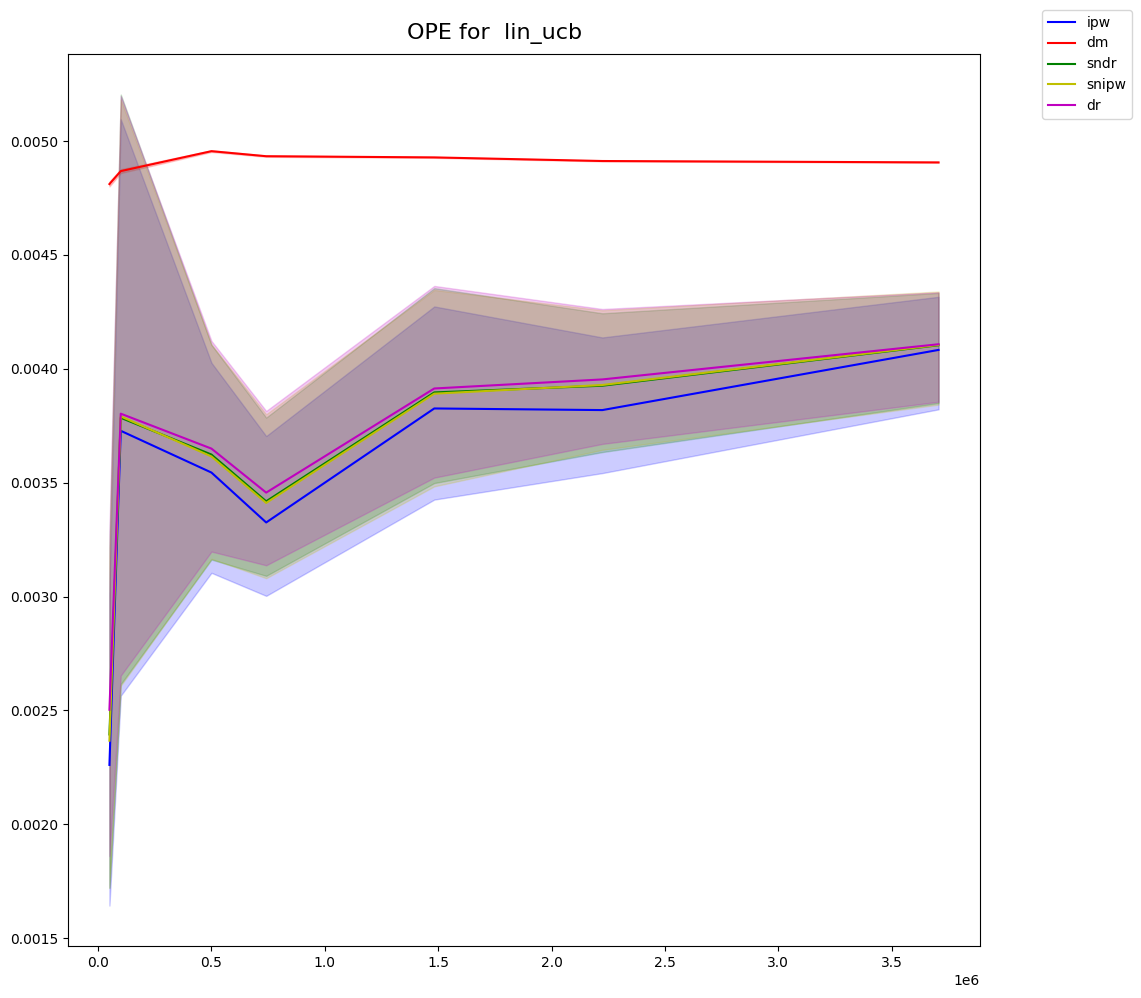

In [ ]:
plot_CIs(CIs, 'lin_ucb')

In [ ]:
rows = []
for i, ci_dict in enumerate(CIs):
  for method, values in ci_dict.items():
      rows.append({
          "test_size": test_sizes[i],
          "Method": method,
          "Mean": values["mean"],
          "95% CI Lower": values["95.0% CI (lower)"],
          "95% CI Upper": values["95.0% CI (upper)"],
          "Size of CI": values["95.0% CI (upper)"] - values["95.0% CI (lower)"]
      })

df = pd.DataFrame(rows)

In [ ]:
rows = []
for i, ci_dict in enumerate(CIs_noisy):
  for method, values in ci_dict.items():
      rows.append({
          "test_size": test_sizes[i],
          "Method": method,
          "Mean": values["mean"],
          "95% CI Lower": values["95.0% CI (lower)"],
          "95% CI Upper": values["95.0% CI (upper)"],
          "Size of CI": values["95.0% CI (upper)"] - values["95.0% CI (lower)"]
      })

df = pd.DataFrame(rows)

In [ ]:
df

,test_size,Method,Mean,95% CI Lower,95% CI Upper,Size of CI
0,50000,ipw,0.001979,0.001380,0.002729,0.001349
1,50000,snipw,0.002083,0.001452,0.002872,0.001419
2,50000,dr,0.002240,0.001529,0.003050,0.001521
3,50000,sndr,0.002106,0.001357,0.002958,0.001601
4,50000,dm,0.004810,0.004799,0.004823,0.000023
5,50000,chips,0.129107,0.121966,0.136361,0.014396
6,50000,chips_mod,0.136656,0.128778,0.145309,0.016531
7,50000,mips,0.003682,0.003038,0.004323,0.001286
8,100000,ipw,0.003450,0.002069,0.004879,0.002810
9,100000,snipw,0.003532,0.002118,0.004994,0.002876


In [ ]:
df.to_csv('df_all_ucb_noisy.csv', index=False)

In [ ]:
df #ucb

,test_size,Method,Mean,95% CI Lower,95% CI Upper,Size of CI
0,50000,ipw,0.002008,0.001488,0.002700,0.001212
1,50000,snipw,0.002113,0.001565,0.002841,0.001275
2,50000,dr,0.002264,0.001715,0.002996,0.001281
3,50000,sndr,0.002131,0.001553,0.002901,0.001348
4,50000,dm,0.004810,0.004797,0.004820,0.000023
5,50000,chips,0.129649,0.121885,0.136938,0.015054
6,50000,chips_mod,0.137327,0.128358,0.145882,0.017524
7,50000,mips,0.002008,0.001488,0.002700,0.001212
8,100000,ipw,0.003456,0.002379,0.004798,0.002418
9,100000,snipw,0.003538,0.002436,0.004911,0.002476


In [ ]:
df.to_csv('df_all_lin_ucb.csv', index=False)

In [ ]:
df#lin ucb

,test_size,Method,Mean,95% CI Lower,95% CI Upper,Size of CI
0,50000,ipw,0.002261,0.001643,0.003012,0.001369
1,50000,snipw,0.002367,0.001720,0.003153,0.001433
2,50000,dr,0.002503,0.001860,0.003289,0.001428
3,50000,sndr,0.002394,0.001722,0.003217,0.001495
4,50000,dm,0.004811,0.004801,0.004822,0.000022
5,100000,ipw,0.003728,0.002565,0.005096,0.002531
6,100000,snipw,0.003791,0.002608,0.005182,0.002574
7,100000,dr,0.003803,0.002653,0.005199,0.002546
8,100000,sndr,0.003785,0.002615,0.005204,0.002589
9,100000,dm,0.004868,0.004860,0.004877,0.000017


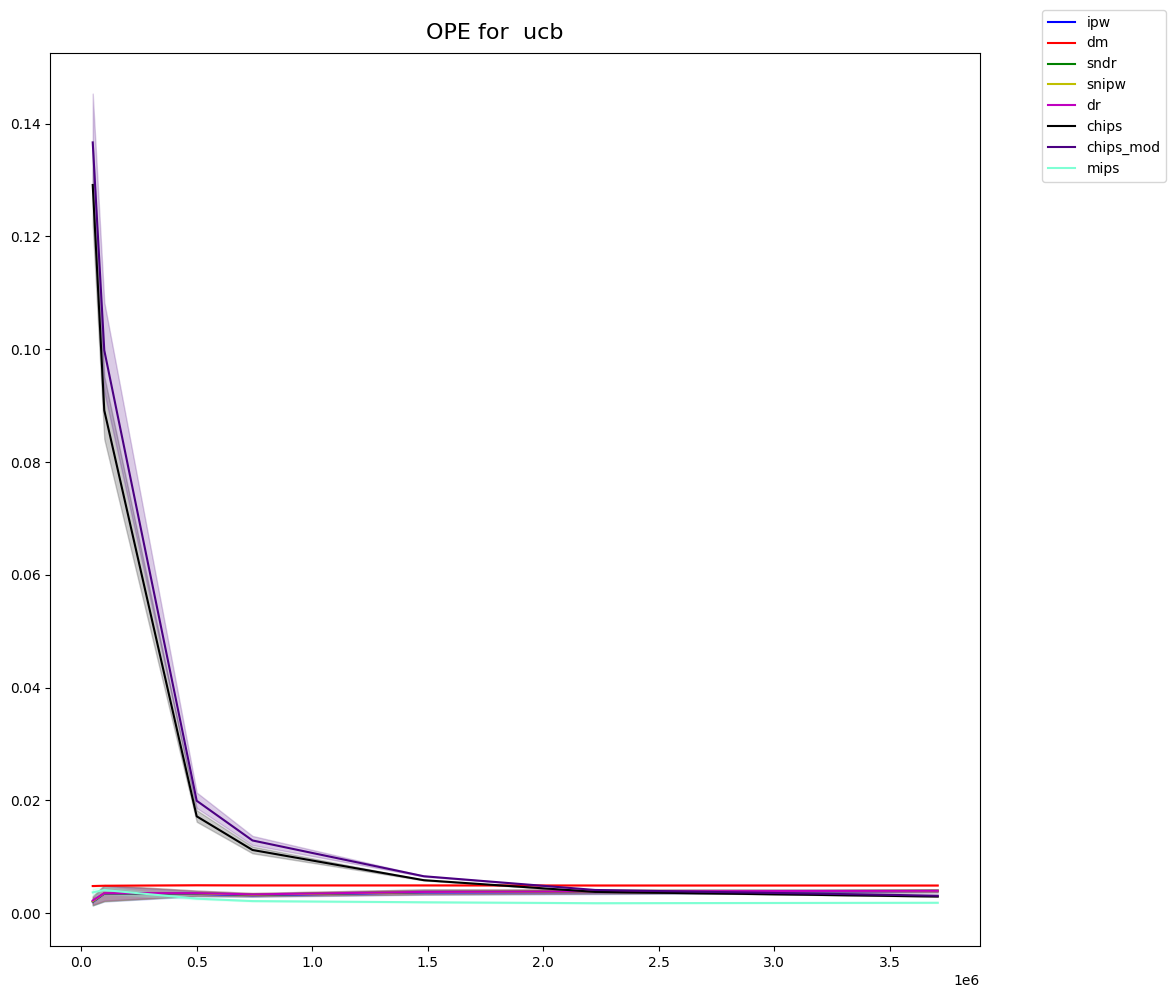

In [ ]:
plot_CIs(CIs, 'ucb')

In [ ]:
import matplotlib.pyplot as plt
def plot_CIs_cut(CIs, model):
    fig, ax = plt.subplots(1, figsize=(10, 10))

    x = test_sizes
    colors = ['b', 'r', 'g', 'y', 'm', 'k', 'indigo', 'aquamarine']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw', 'dr', 'mips']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        i+=1

    fig.suptitle("OPE for " + " " + model, fontsize=16)
    fig.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout()

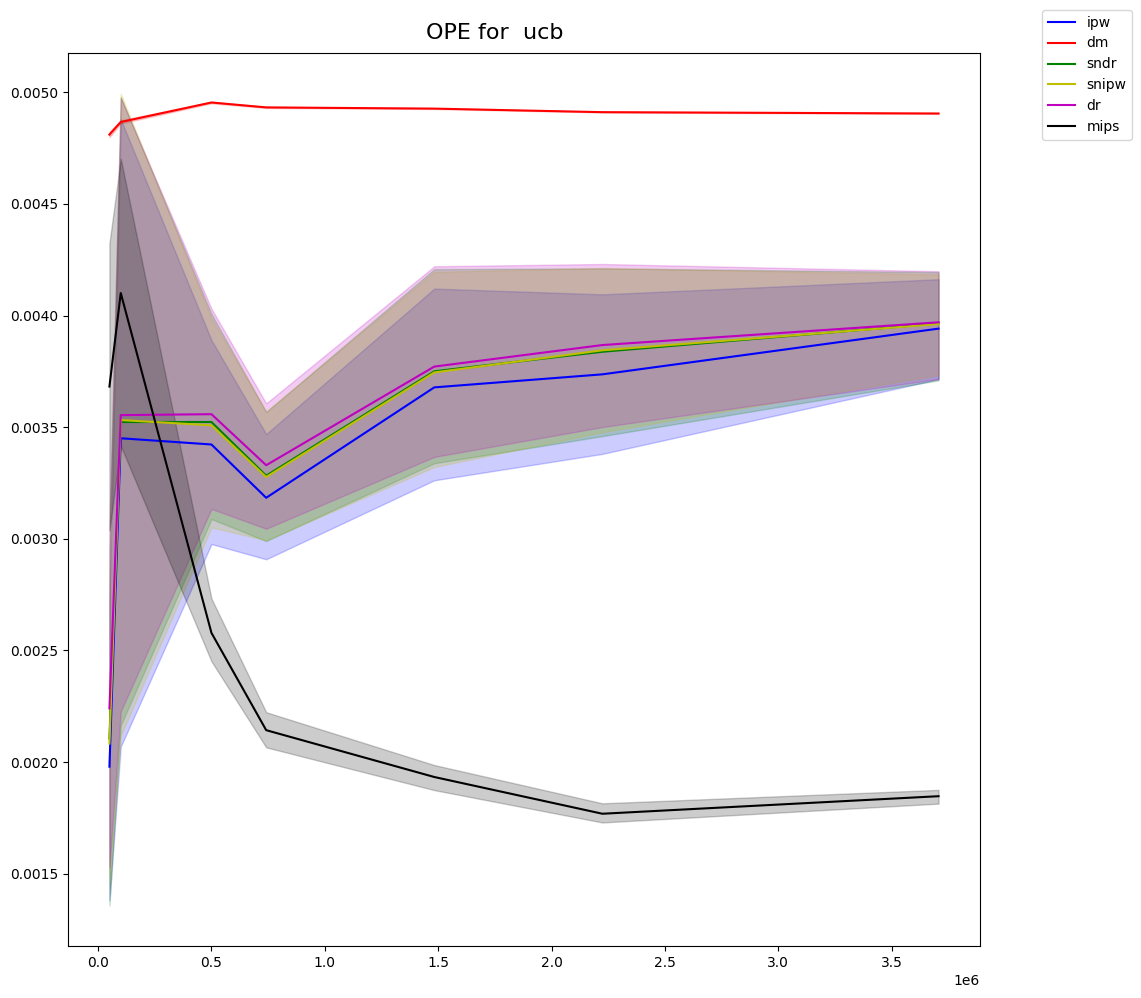

In [ ]:
plot_CIs_cut(CIs, 'ucb')

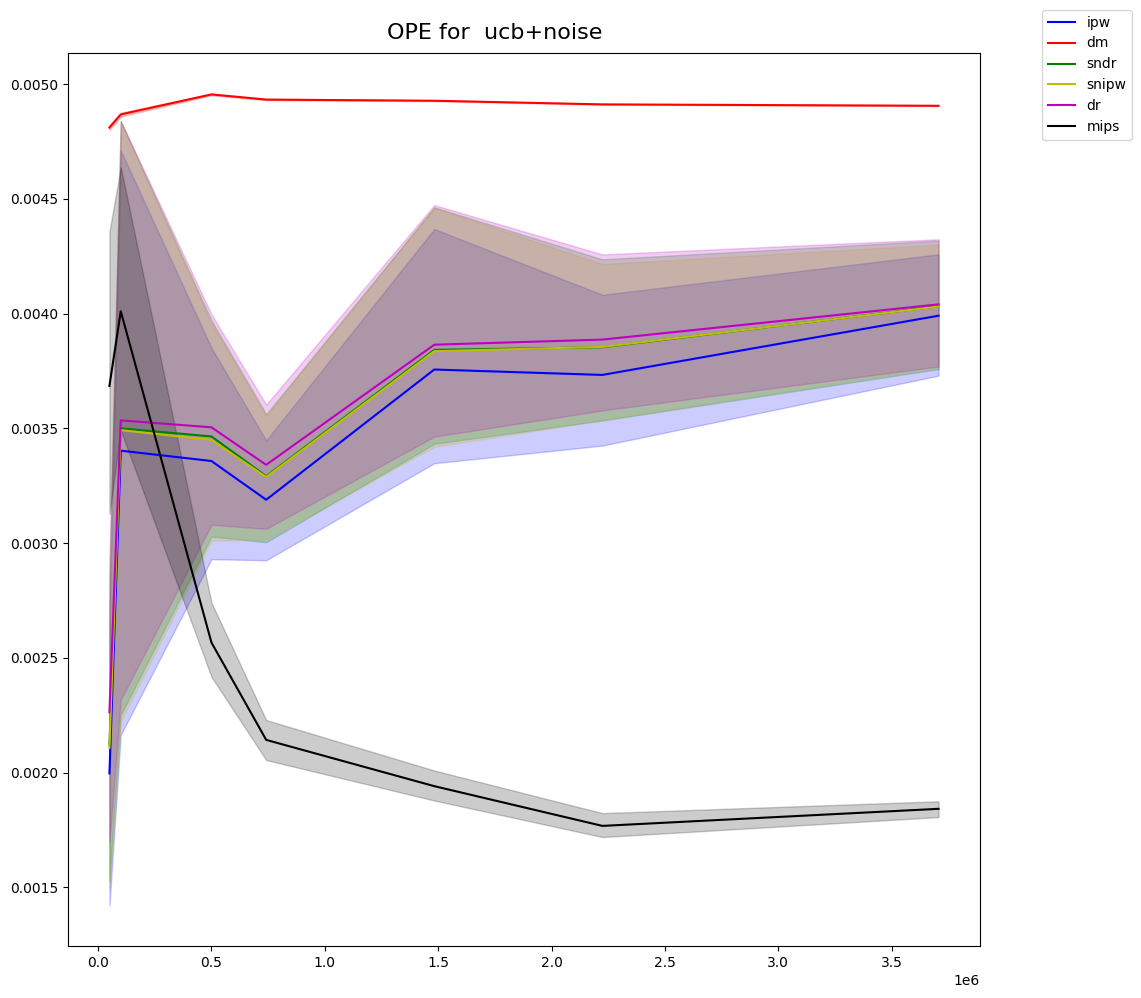

In [ ]:
plot_CIs_cut(CIs_noisy, 'ucb+noise')

In [ ]:
import matplotlib.pyplot as plt
def plot_CIs_pair(CIs, CIs_noisy, model):
    fig, ax = plt.subplots(5, figsize=(10, 50))

    x = test_sizes
    colors = ['b', 'r', 'g', 'y', 'm', 'k', 'indigo', 'aquamarine']
    i = 0
    for name in ['ipw', 'sndr', 'snipw', 'dr', 'mips']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name+'true', color = colors[0])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])

        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_noisy]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_noisy]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_noisy]

        ax[i].plot(x, y_est, '-', label=name+'noisy', color = colors[1])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
        i+=1

    fig.suptitle("OPE for " + " " + model, fontsize=16)
    fig.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout()

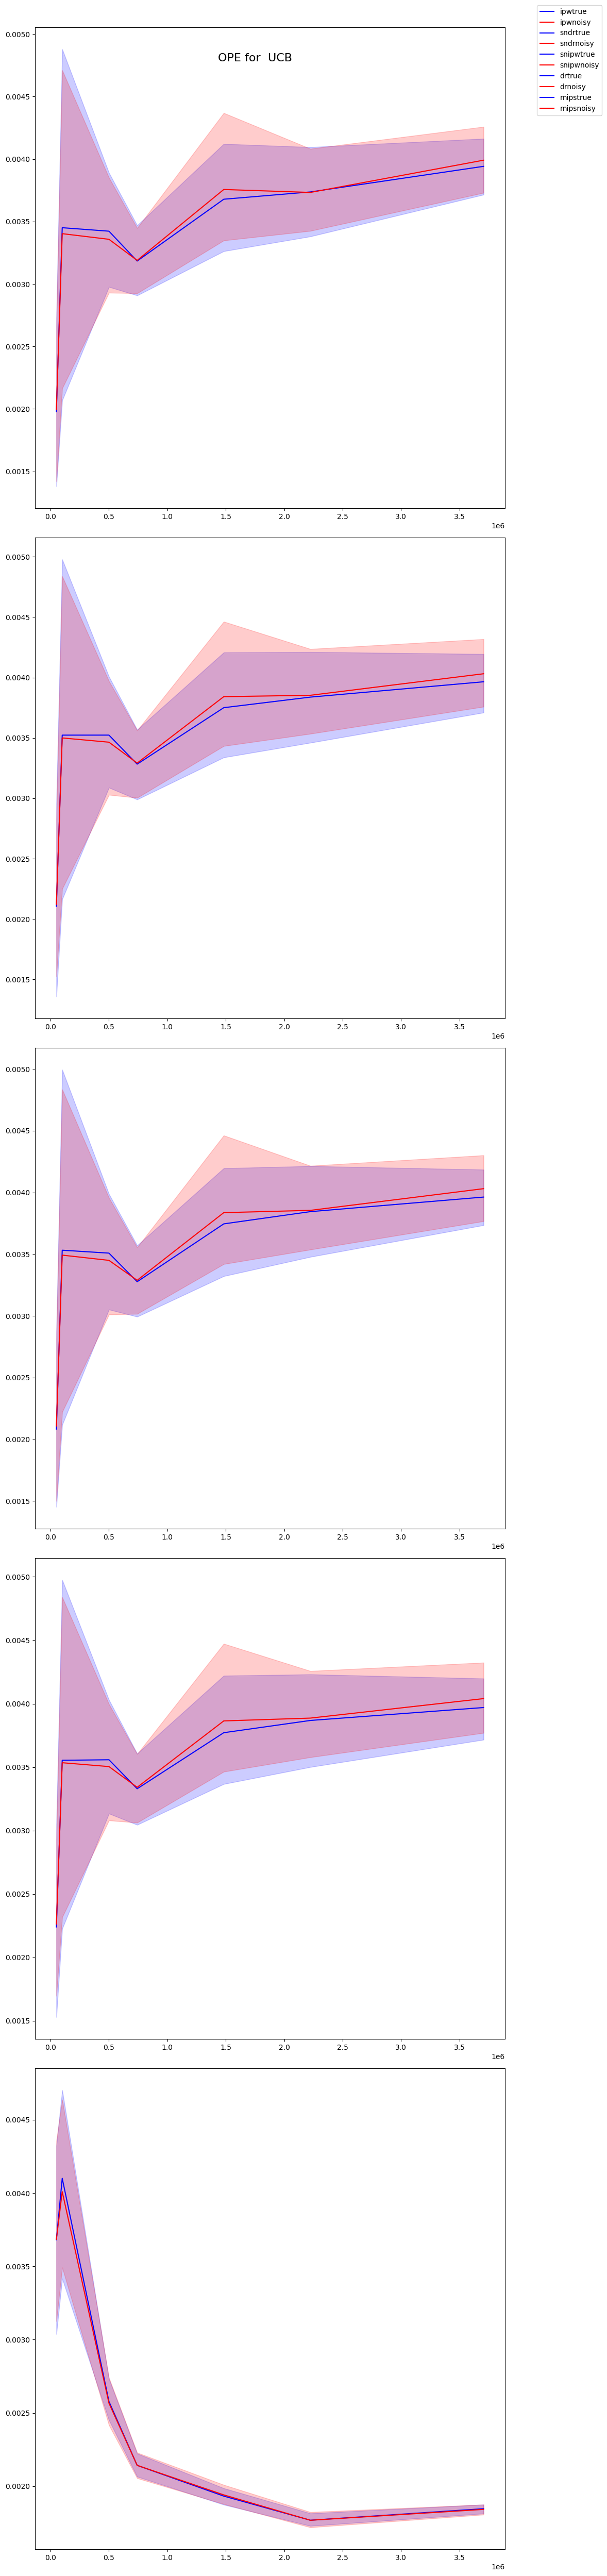

In [ ]:
plot_CIs_pair(CIs, CIs_noisy, 'UCB')

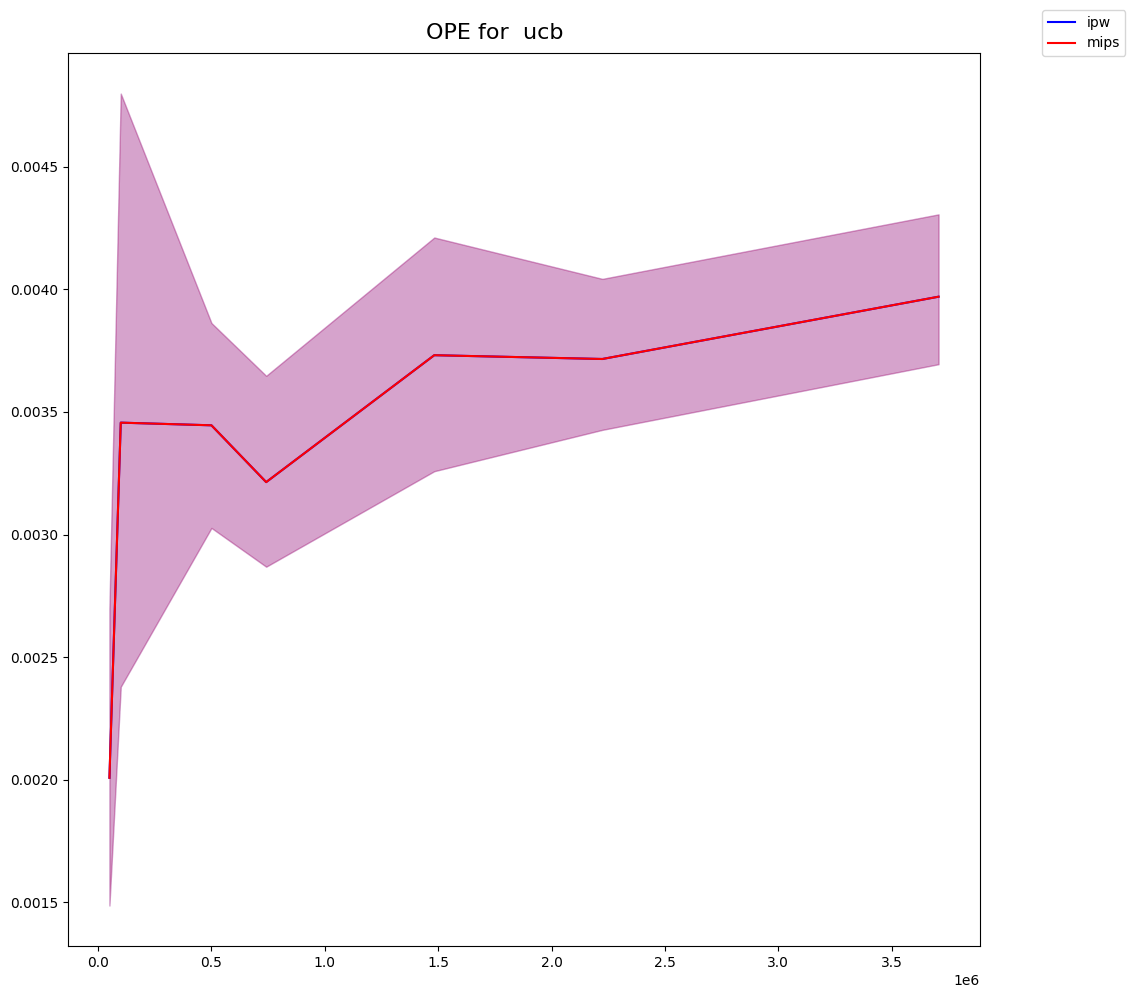

In [ ]:
plot_CIs_cut_(CIs, 'ucb')